# Exercise sheet 7
## Exercise 1

For this exercise, you will need to load the dataset (milk) from the rethinking package that we discussed already in the class.

Lade nötiges Paket: rstan

Lade nötiges Paket: StanHeaders


rstan version 2.26.16 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file

Lade nötiges Paket: cmdstanr

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: D:/Users/Immanuel/Documents/.cmdstan/cmdstan-2.31.0

- CmdStan version: 2.31.0

Lade nötiges Paket: parallel

rethinking (Version 2.31)


Attache Paket: 'rethinking'


Das folgende Objekt ist maskiert 'package:rstan':

    stan


Das folgende Objekt ist maskiert 'package:stats':

    rstudent




              clade                 species     kcal.per.g        perc.fat    
 Ape             :9   A palliata        : 1   Min.   :0.4600   Min.   : 3.93  
 New World Monkey:9   Alouatta seniculus: 1   1st Qu.:0.4900   1st Qu.:21.22  
 Old World Monkey:6   Callimico goeldii : 1   Median :0.6000   Median :36.84  
 Strepsirrhine   :5   Callithrix jacchus: 1   Mean   :0.6417   Mean   :33.99  
                      Cebuella pygmaea  : 1   3rd Qu.:0.7300   3rd Qu.:46.08  
                      Cebus apella      : 1   Max.   :0.9700   Max.   :55.51  
                      (Other)           :23                                   
  perc.protein    perc.lactose        mass       neocortex.perc 
 Min.   : 7.37   Min.   :27.09   Min.   : 0.12   Min.   :55.16  
 1st Qu.:13.00   1st Qu.:37.80   1st Qu.: 1.62   1st Qu.:64.54  
 Median :15.80   Median :48.64   Median : 3.47   Median :68.85  
 Mean   :16.40   Mean   :49.61   Mean   :14.73   Mean   :67.58  
 3rd Qu.:20.77   3rd Qu.:60.12   3rd Qu.:10

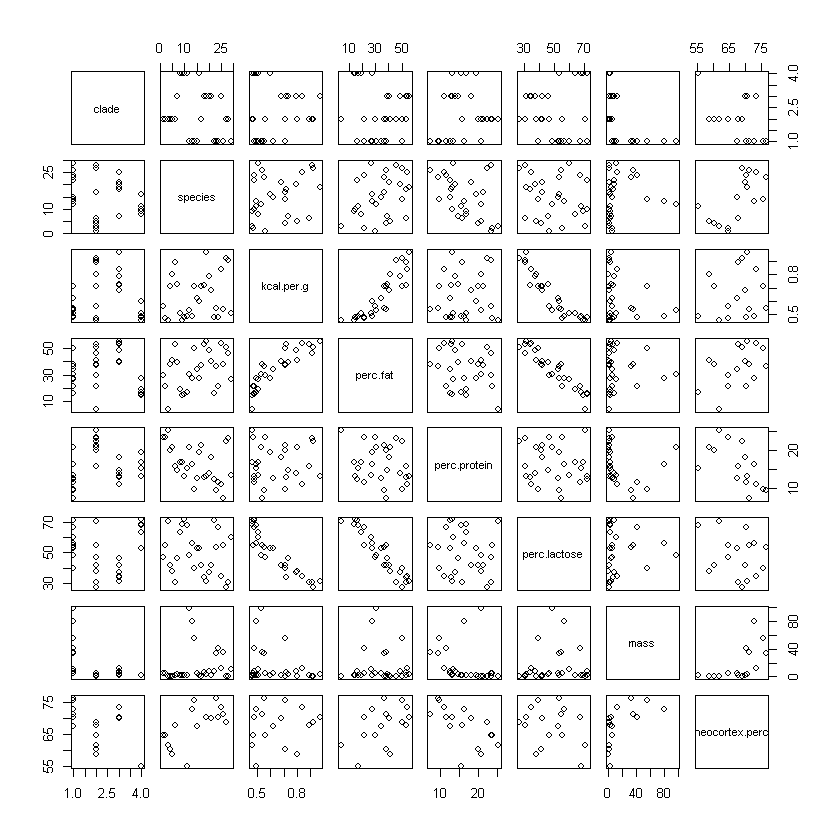

In [1]:
library(rethinking)
data(milk)
d <- milk
summary(d)
pairs(d)

In the class we treated all primates together. You can use categorical variables to characterise different sub-populations of a same sample. To this end, the following self-explanatory command can be used.

In [2]:
unique(d$clade)

[1] Strepsirrhine    New World Monkey Old World Monkey Ape             
Levels: Ape New World Monkey Old World Monkey Strepsirrhine

1. Build a single model including all clades with an appropriate choice of “dummy” variables (switching a predictor on and off). Compute the average milk energy for each clade along with credible intervals of your choice. Compare these values. How significant are the differences between each clade?

In [3]:
d$clade.N <- ifelse(d$clade == "New World Monkey",1, ifelse(d$clade == "Ape", 2, ifelse(d$clade == "Old World Monkey", 3, ifelse(d$clade == "Strepsirrhine", 4, 0))))


We enumerate the clades by 1. New World Monkey, 2. Ape, 3. Old World Monkey and 4. Strepsirrhine.
Next we build a model with categorical varuable `clade.N`.

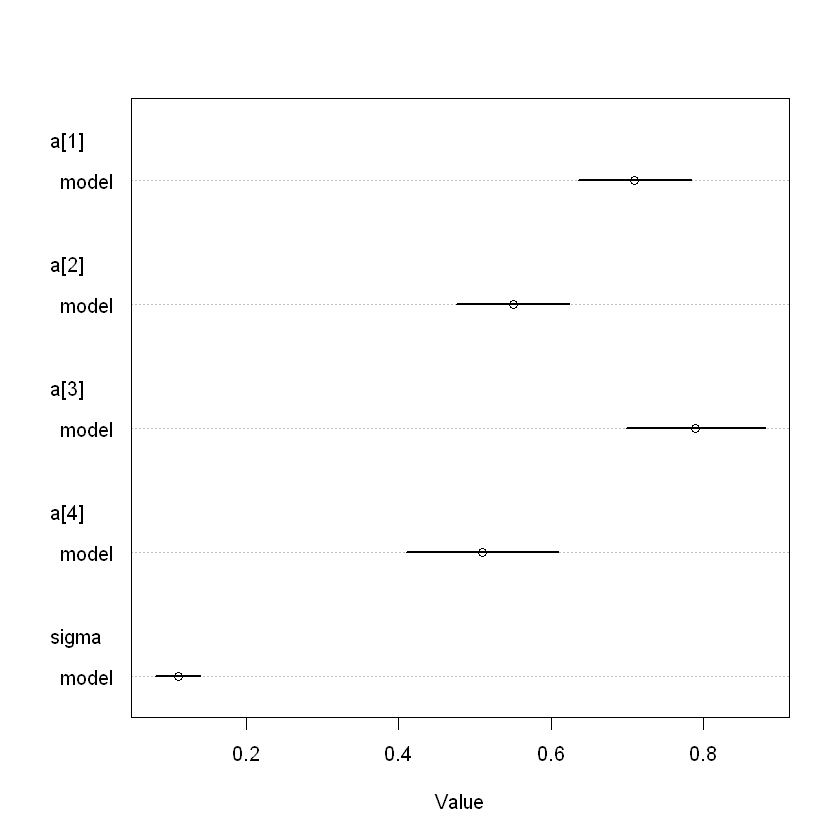

In [4]:
model <- map(
	alist(
		kcal.per.g ~ dnorm(mu, sigma),
		mu <- a[clade.N],
		a[clade.N] ~ dnorm(0.5, 0.5),
		sigma ~ dunif(0, 5)
	),
	data = d
)
plot(coeftab(model))

This plot shows that the differences are significant, as the means and their deviations do not always overlap.

2. Design a model that includes the perc.fat in the milk and the log(mass) of the individual. Characterise the differences between the clades.

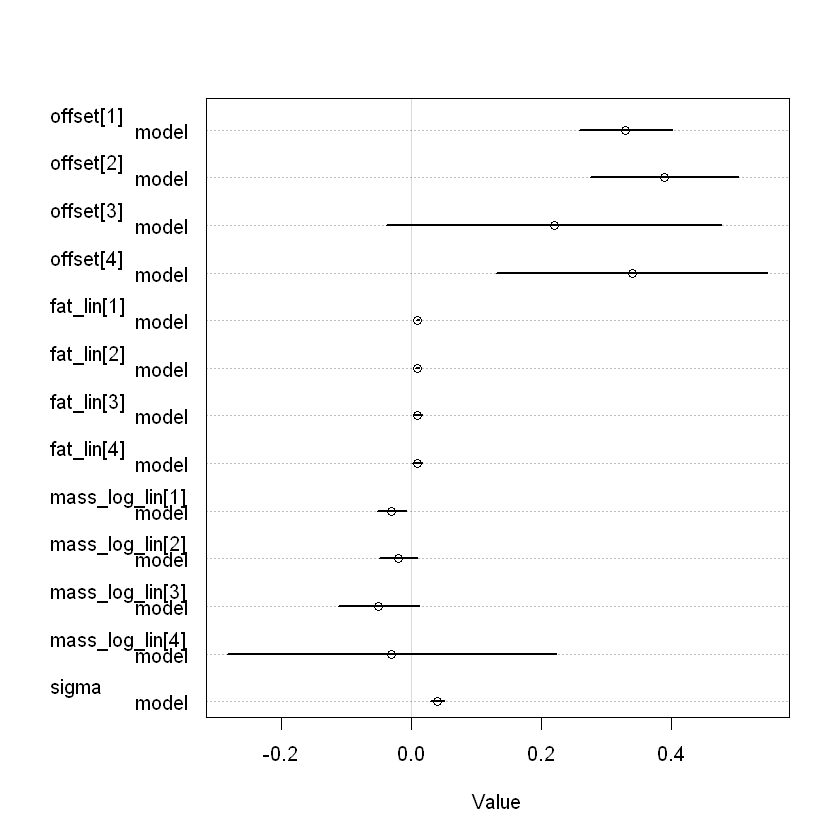

In [5]:
model <- map(
	alist(
		kcal.per.g ~ dnorm(mu, sigma),
		mu <- offset[clade.N] + fat_lin[clade.N] * perc.fat + mass_log_lin[clade.N] * log(mass),
		offset[clade.N] ~ dnorm(0.5, 0.5),
		fat_lin[clade.N] ~ dnorm(0, 1),
		mass_log_lin[clade.N] ~ dnorm(0, 1),
		sigma ~ dunif(0, 5)
	),
	data = d
)

post <- extract.samples(model)

plot(coeftab(model))

In [9]:
credible_iterval <- 0.91

for (monkey in c(1, 2, 3, 4)) {
monkey_data <- d[ d$clade.N == monkey, ]

mu.link <- function(perc.fat, mass) post$offset[monkey] + post$fat_lin[monkey] * perc.fat + post$mass_log_lin[monkey] * mass

perc.fat.seq <- seq(from = min(monkey_data$perc.fat), to = max(monkey_data$perc.fat), by = 0.01)
mass.seq <- seq(from = min(monkey_data$mass), to = max(monkey_data$mass), by = 0.01)
perc.fat.mean <- mean(monkey_data$perc.fat)
mass.mean <- mean(monkey_data$mass)

# For each weight value we calculate a 91 percent credible interval
perc.fat.mu <- sapply(perc.fat.seq, mu.link, mass = mass.mean)
perc.fat.mu.mean <- apply(perc.fat.mu, 2, mean)
perc.fat.mu.HPDI <- apply(perc.fat.mu, 2, HPDI, prob = credible_iterval)
mass.mu <- sapply(mass.seq, mu.link, perc.fat = perc.fat.mean)
mass.mu.mean <- apply(mass.mu, 2, mean)
mass.mu.HPDI <- apply(mass.mu, 2, HPDI, prob = credible_iterval)

# Plotting kcal.per.g to perc.fat
plot(kcal.per.g ~ perc.fat, monkey_data)
lines(perc.fat.seq, perc.fat.mu.mean)
shade(perc.fat.mu.HPDI, perc.fat.seq)

# We calculate the 91 percent credible interval of the height variables by taking into account the uncertainty of the slope and the standard deviation
perc.fat.sim.kcal.per.g <- sim(model, data=list(perc.fat = perc.fat.seq))
perc.fat.kcal.per.g.HPDI <- apply(perc.fat.sim.kcal.per.g, 2, HPDI, prob = credible_iterval)
shade(perc.fat.kcal.per.g.HPDI, perc.fat.seq)

# Plotting kcal.per.g to mass
plot(kcal.per.g ~ mass, monkey_data)
lines(mass.seq, mass.mu.mean)
shade(mass.mu.HPDI, mass.seq)

# We calculate the 91 percent credible interval of the height variables by taking into account the uncertainty of the slope and the standard deviation
mass.sim.kcal.per.g <- sim(model, data=list(mass = mass.seq))
mass.kcal.per.g.HPDI <- apply(mass.sim.kcal.per.g, 2, HPDI, prob = credible_iterval)
shade(mass.kcal.per.g.HPDI, mass.seq)

}

ERROR: Error in apply(perc.fat.mu, 2, mean): dim(X) muss positive Länge haben


There was an attempt to produce counterfactual plots, but it seems that R did not intend for us to come that far.

First we observe that the Strepsirrhine have a wide array of different correlations between their body mass and the energy in their milk. Next we can say that

3. The dataset provides for each individual the percentage of proteines (perc.protein) in the milk, in addition to lactose and fat. Examine the data and determine whether including this variable helps in better constraining the source of milk energy for each clade.

Looking at the data points, the lactose doesnt seem to be correlated to any of the predictors we considered. Thus I assume it is irrelevant to the discussion.